# full gene set prediction from latent

In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_versions()

/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


-----
anndata     0.7.6
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                         8.4.0
anndata                     0.7.6
backcall                    0.2.0
cffi                        1.14.1
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dask                        2021.06.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints                 0.3
fsspec                      2021.05.0
google                      NA
h5py                        2.9.0
igraph                      0.8.3
ipykernel                   6.5.0
ipython_genutils            0.2.0
jedi                        0.18.1
joblib                      1.1.0
kiwisolver                  1.3.2
leidenalg                   0.8.3
llvmlite                    0.37.0
matplotlib                  3.3.4
matplotlib_inline           NA
mpl_toolkits   

In [2]:
import pkg_resources
pkg_resources.get_distribution('scvi-tools').version

'0.16.3'

In [3]:
project_dir = "/lustre/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/HLCA_reproducibility"
original_adata_path = f'{project_dir}/data/HLCA_core_h5ads/HLCA_v1.h5ad'
reference_model_path = f'{project_dir}/results/scANVI_integration/scanvi_model'

Observe clustering before reconstruction. Note: importing pytorch (via `scvi`) will cause LLVM conflicts and prevent numba -> `sc.pp.neighbors` to work.

In [4]:
full_adata = sc.read(original_adata_path)
full_adata

AnnData object with n_obs × n_vars = 584884 × 28527
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'ori

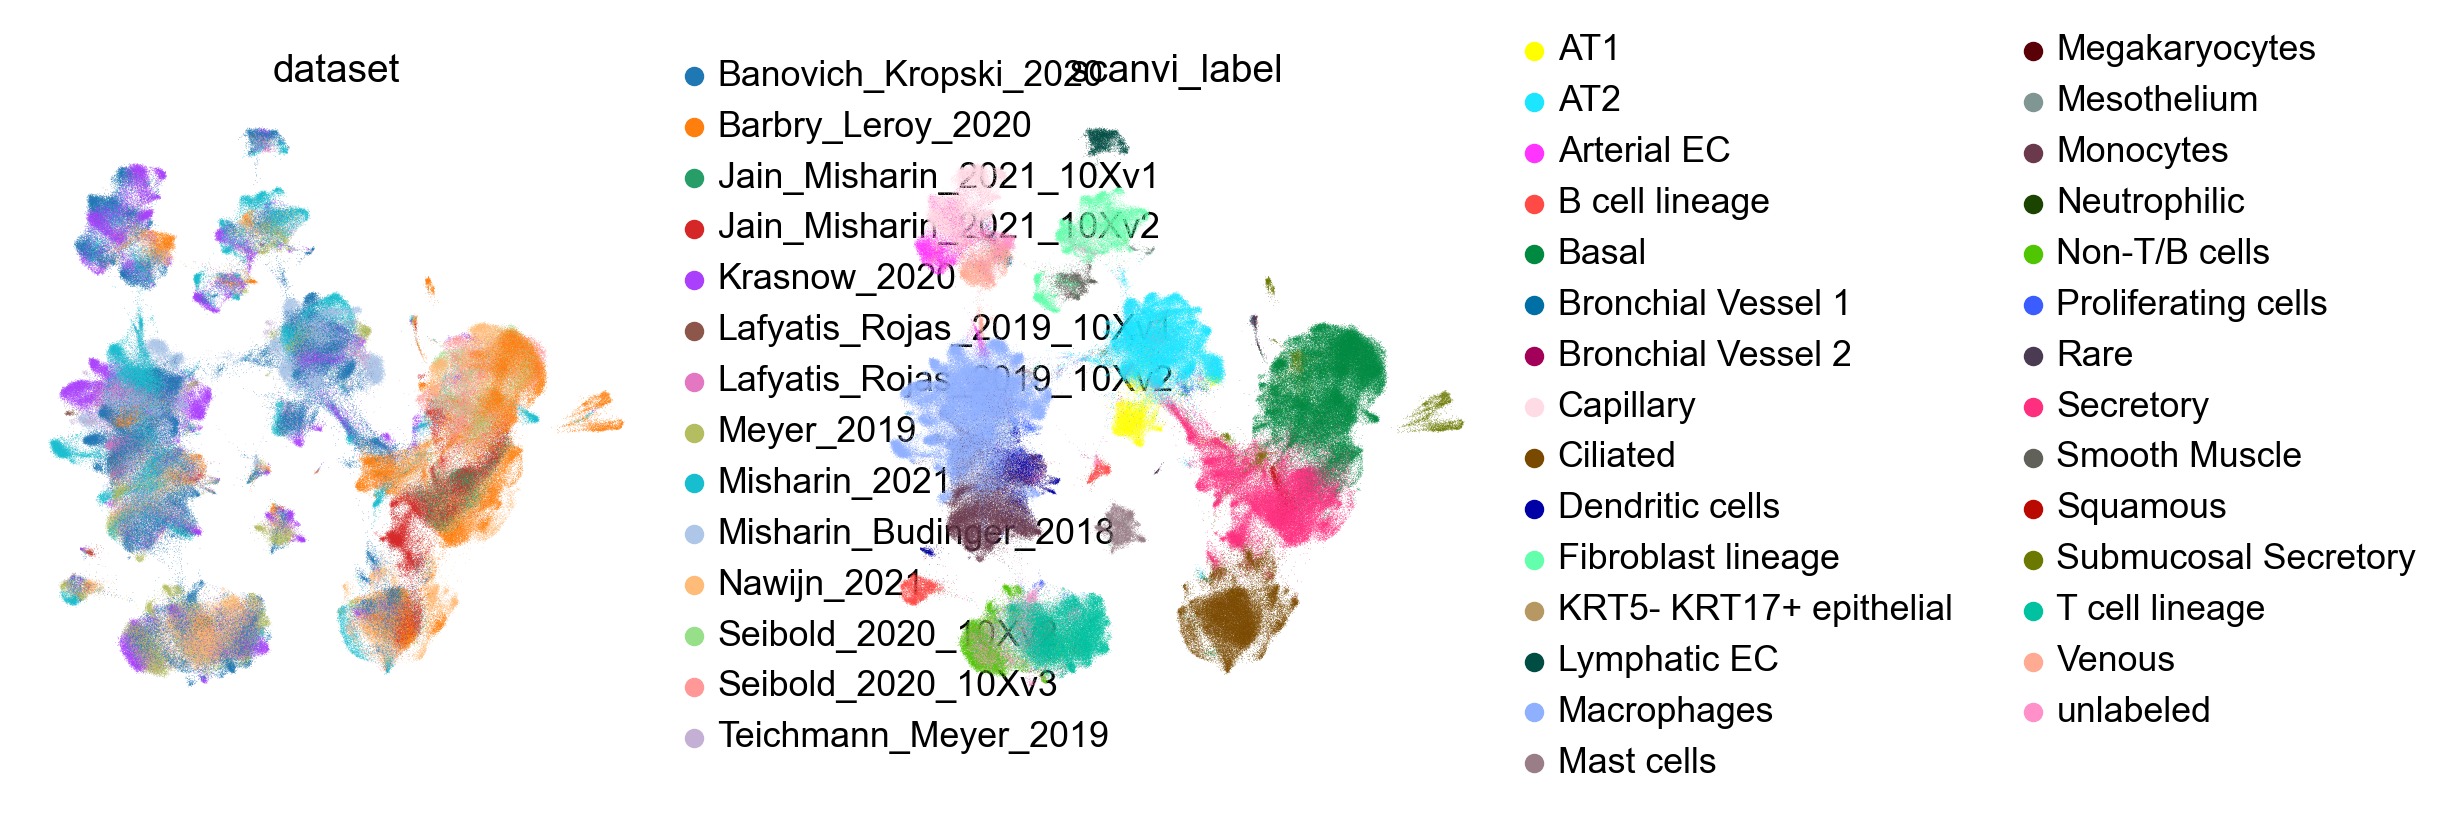

In [5]:
sc.pl.umap(full_adata, color=['dataset', 'scanvi_label'])

We'll run the example on a subset of the cells to reduce runtime.

In [5]:
hvgs = full_adata.var_names[full_adata.var['highly_variable']]
nonhvgs = full_adata.var_names[~full_adata.var['highly_variable']]
subset = full_adata[:, hvgs][full_adata.obs.scanvi_label.isin(['Secretory', 'Ciliated'])]

2022-06-15 14:20:37.836898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


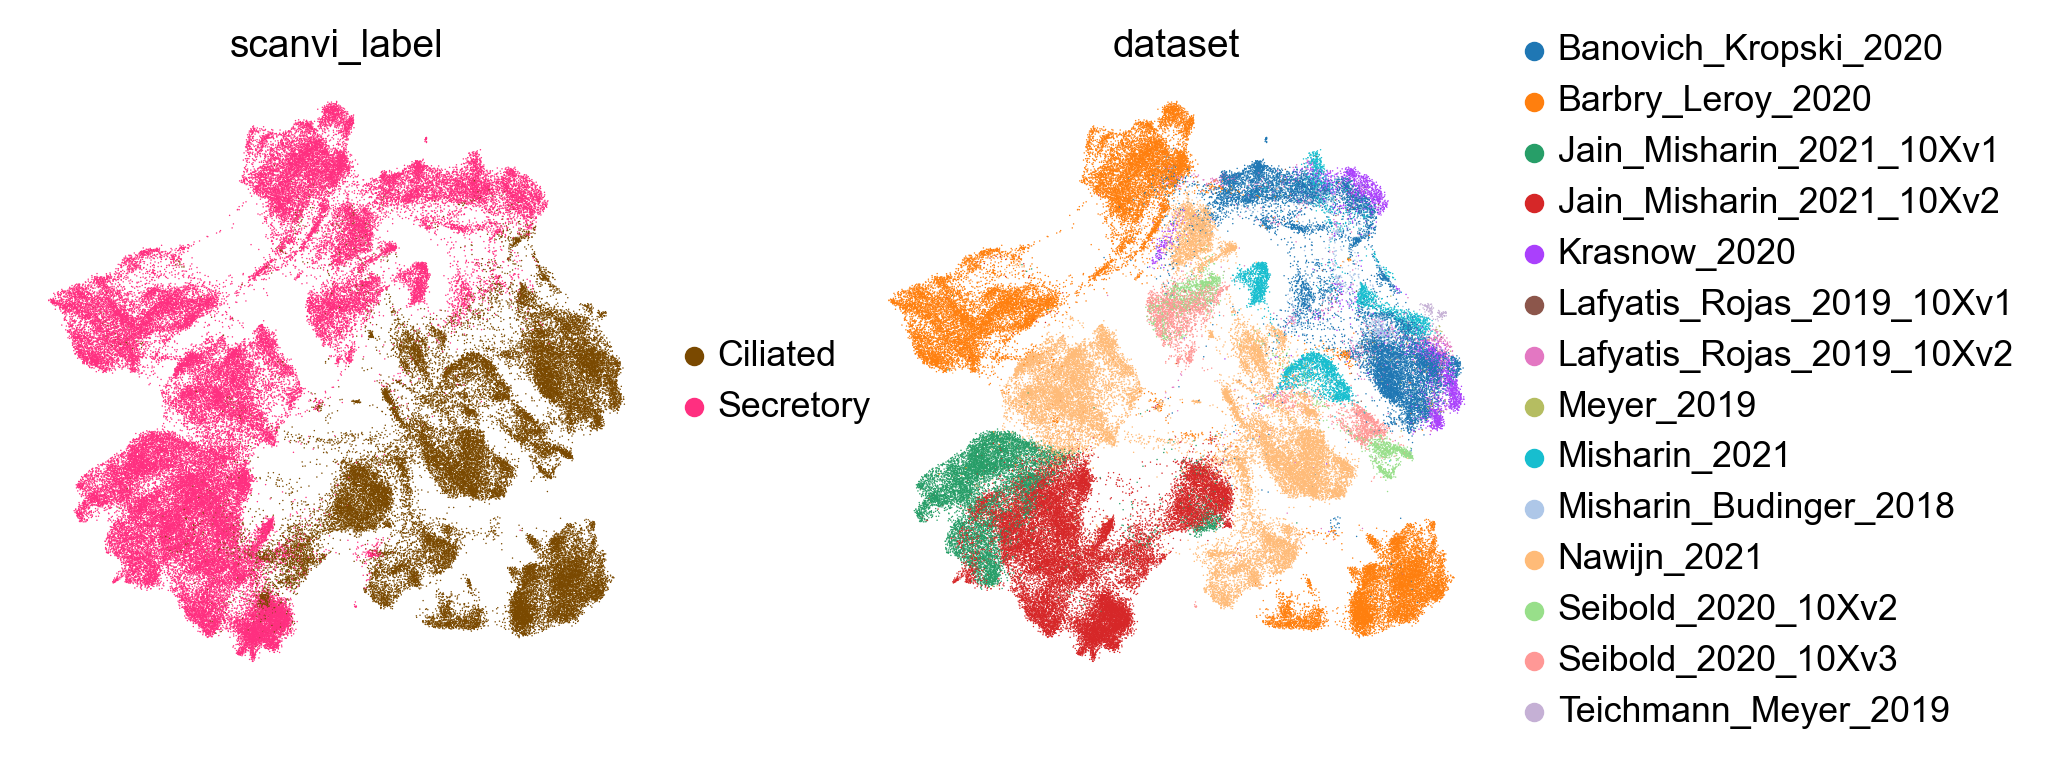

CPU times: user 5min 31s, sys: 59.4 s, total: 6min 30s
Wall time: 3min 35s


In [7]:
%%time
sc.tl.pca(subset)
sc.pp.neighbors(subset)
sc.tl.umap(subset)
sc.pl.umap(subset, color=['scanvi_label', 'dataset'])

## convert legacy scANVI model (skip on rerun)

Copy the legacy model directory over and instantiate new model inside.

In [6]:
!cp -r /lustre/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/HLCA_reproducibility/results/scANVI_integration/scanvi_model/ ~/projects/hlca

In [7]:
import scvi

# convert old model to new version
scvi.model.SCANVI.convert_legacy_save(
    dir_path=reference_model_path,
    output_dir_path="./scanvi_model/",
    overwrite=True
)

Global seed set to 0


## load model

This produces a corrected gene expression matrix where all batches have been aligned to the same batch.

In [6]:
import scvi

adata = full_adata[:, hvgs].copy()
source_model = scvi.model.SCANVI.load('./scanvi_model/', adata)
source_model

Global seed set to 0


INFO     File ./scanvi_model/model.pt already downloaded                                     


/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scvi/model/base/_utils.py:135: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  "var_names for adata passed in does not match var_names of "
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scvi/data/_utils.py:158: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  category, alternate_column_key


ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, 
dispersion: gene, gene_likelihood: nb
Training status: Trained

In [7]:
source_model.summary_stats

attrdict({'n_cells': 584884, 'n_vars': 2000, 'n_batch': 14, 'n_labels': 29, 'n_extra_categorical_covs': 0, 'n_extra_continuous_covs': 0})

## reconstruct into the same batch with original model

In [41]:
target_batch = 'Meyer_2019'
recon = source_model.get_normalized_expression(subset, transform_batch=target_batch)

# construct anndata
recon_adata = ad.AnnData(recon, obs=subset.obs, var=subset.var)
recon_adata.uns['scanvi_label_colors'] = subset.uns['scanvi_label_colors']

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [44]:
# recon_adata.write('recon_test.h5ad')

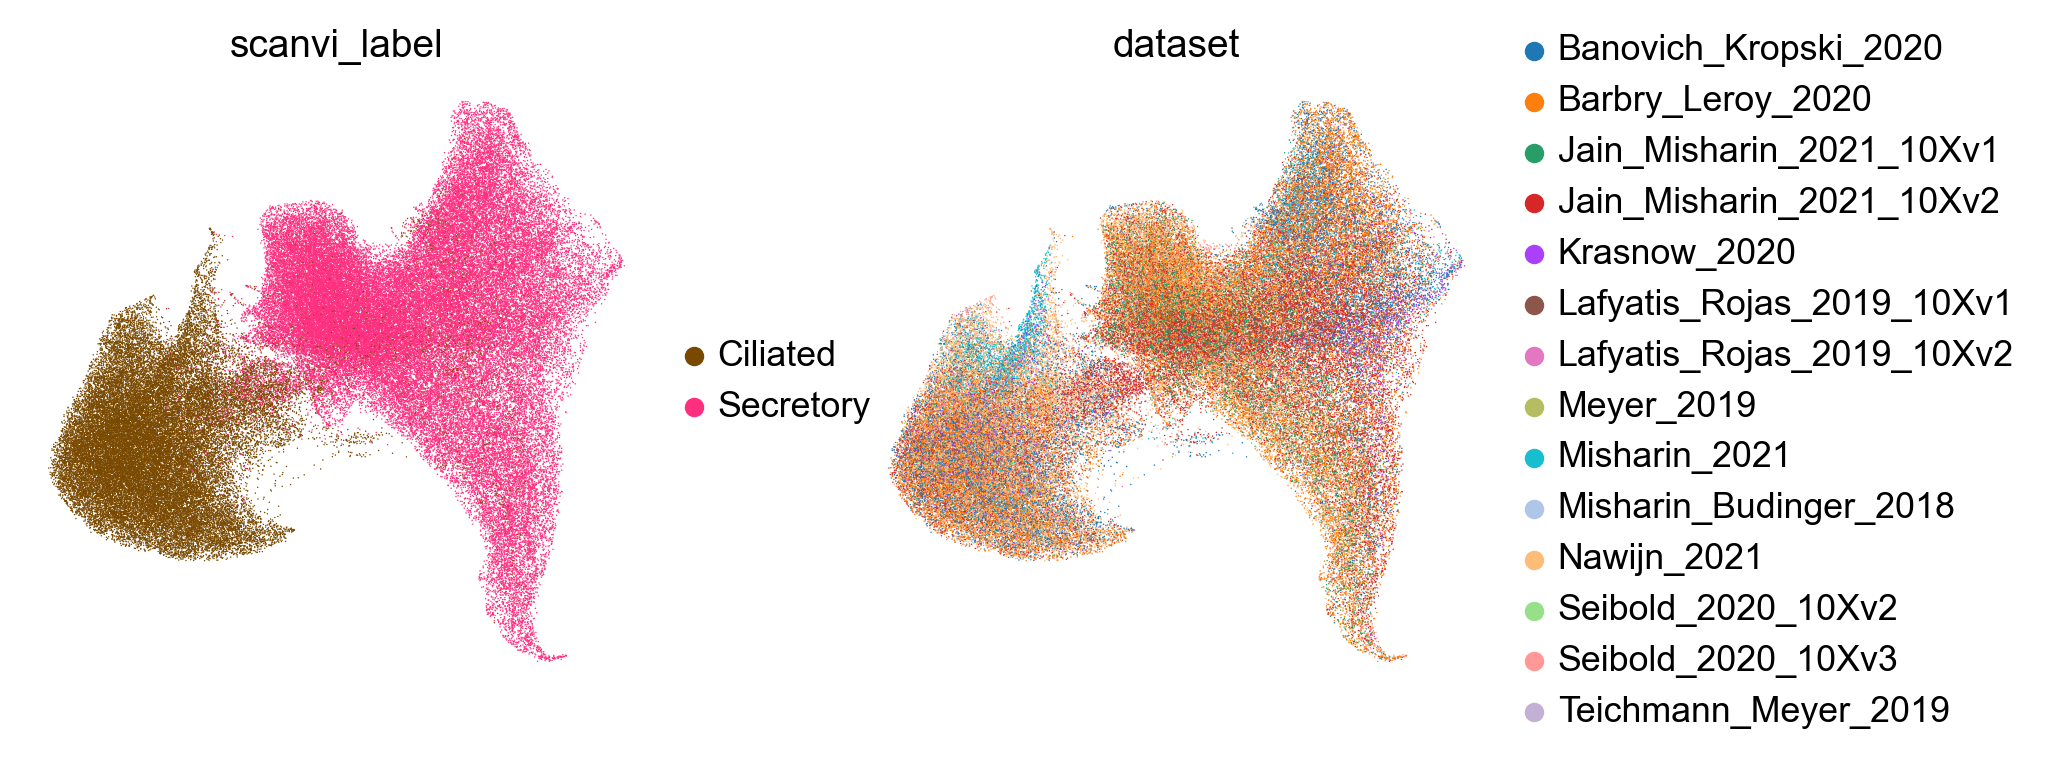

CPU times: user 5min 27s, sys: 1min 4s, total: 6min 31s
Wall time: 1min 55s


In [16]:
%%time
sc.tl.pca(recon_adata)
sc.pp.neighbors(recon_adata)
sc.tl.umap(recon_adata)
sc.pl.umap(recon_adata, color=['scanvi_label', 'dataset'])

Yay! The batch effects are far more corrected now than in the original gene space.

## reconstruct full gene expression space

Although we now have the "corrected" gene expression matrix, we still don't have expression values for all the genes. We will now impute the remaining genes from the latent space by extending the model. We prefer this to typical imputation approaches because it uses the existing model's knowledge of the latent variables (both latent embedding and categorical features) to infer the remaining information.

In [8]:
full_subset = full_adata[full_adata.obs.scanvi_label.isin(['Secretory', 'Ciliated'])].copy()

### with linear regression (baseline)

In [9]:
# get latent layer
z = source_model.get_latent_representation(subset)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [10]:
# demonstrate imputation with linear regression as a baseline
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(z, full_subset.X.toarray())  # technically needs to train on full to be 100% fair

LinearRegression()

Measure performance:

In [11]:
pred = reg.predict(z)
print('all:', r2_score(full_subset.X.toarray(), pred))  # same as reg.score()
print('hvgs:', r2_score(full_subset[:, hvgs].X.toarray(), pred[:, full_adata.var['highly_variable'].values]))
print('non-hvgs:', r2_score(full_subset[:, nonhvgs].X.toarray(), pred[:, ~full_adata.var['highly_variable'].values]))

all: 0.04326613852818817
hvgs: 0.1112504085671867
non-hvgs: 0.03814047259996421


In [12]:
full_subset.layers['linreg_pred'] = pred

In [62]:
# full_subset.write('recon_test.h5ad')

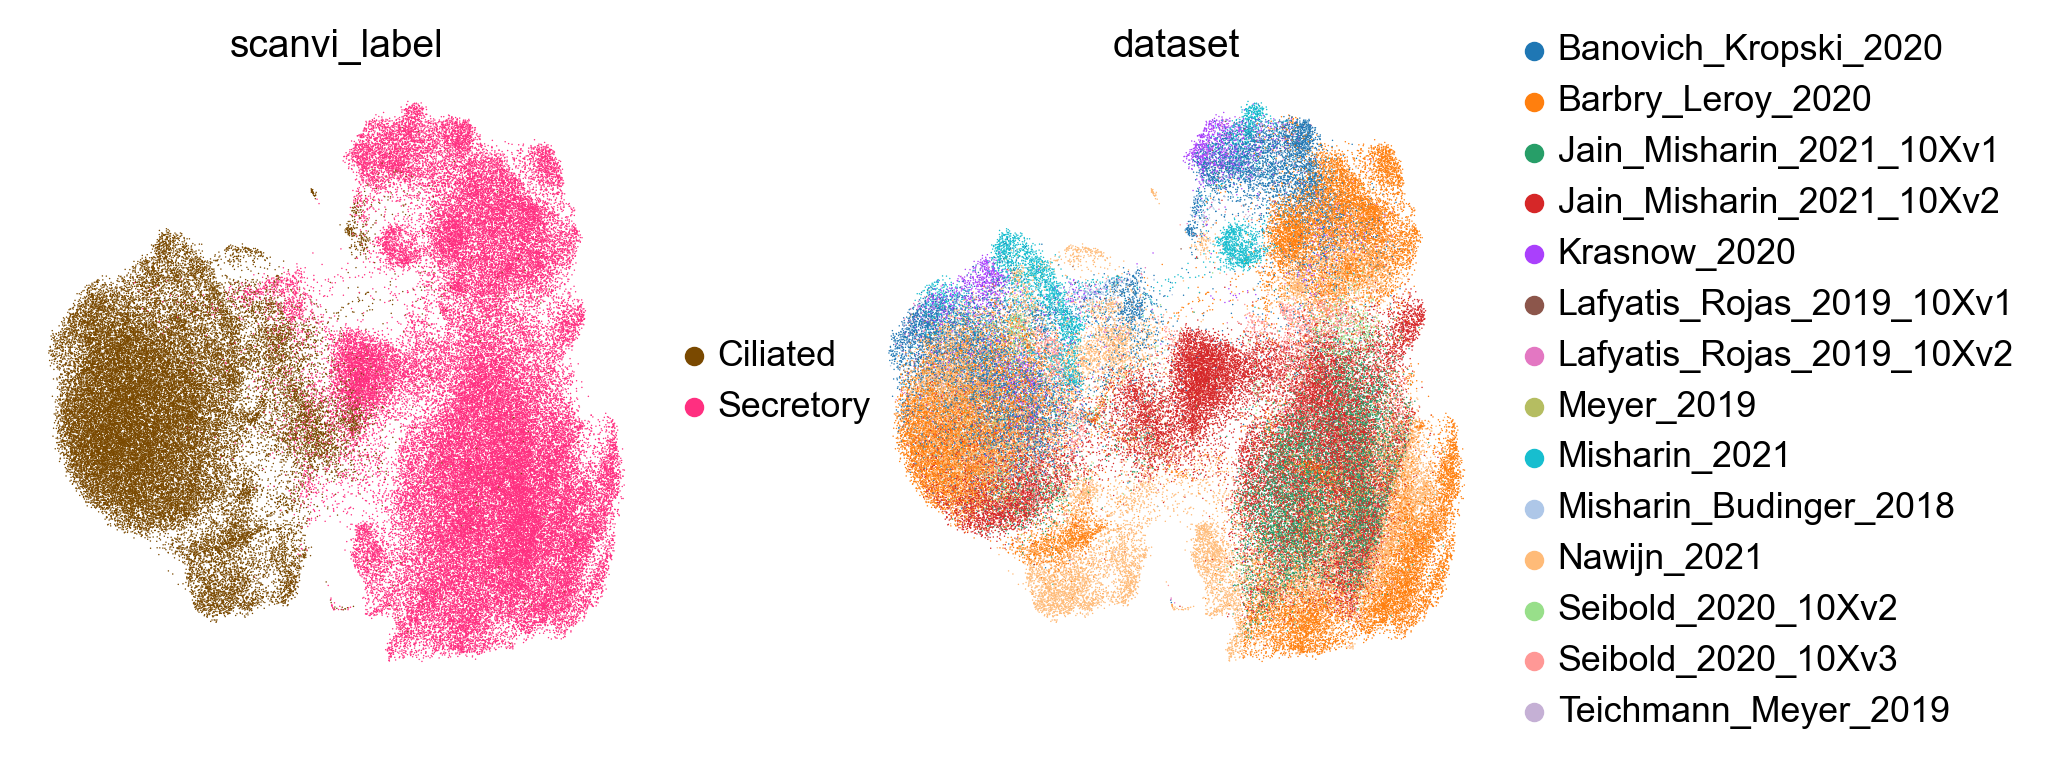

CPU times: user 7min 40s, sys: 41.8 s, total: 8min 22s
Wall time: 2min 20s


In [24]:
%%time
sc.tl.pca(subset)
sc.pp.neighbors(subset)
sc.tl.umap(subset)
sc.pl.umap(subset, color=['scanvi_label', 'dataset'])

It's more integrated than I thought, given that accurate predicted values resembling the truth will have batch information. This indicates that the latent embedding contains very little batch information and thus, this model cannot learn to reconstruct sources of variation related to batch, producing a fairly integrated UMAP (where, arguably, a lack of integration is due to real biological difference).

### with modified model

To do this, we will instantiate a new model with the same architecture, but more features. We then set additional input feature weights to zero and freeze everything except the decoder.

Modify based on https://github.com/scverse/scvi-tools/blob/096099e34568b1bf94aad5273b9f92c202c9c755/scvi/model/base/_archesmixin.py#L125-L138

In [13]:
import torch

# instantiate new model with updated sizes
attr_dict, var_names, old_state_dict = scvi.model.base._archesmixin._get_loaded_data(source_model)
source_model.setup_anndata(full_adata, **attr_dict['registry_']['setup_args'])

new_model = scvi.model.SCANVI(
    full_adata,
    **source_model.init_params_['non_kwargs'],
    **source_model.init_params_['kwargs']['model_kwargs'],
)
new_model.to_device(source_model.device)

# get new tensors
_, new_var_names, new_state_dict = scvi.model.base._archesmixin._get_loaded_data(new_model)

# model tweaking
n_feat_new = len(new_var_names)
feature_indices = [list(new_var_names).index(g) for g in var_names]  # kinda slow
batch_indices = list(range(n_feat_new, n_feat_new+source_model.adata_manager.summary_stats['n_batch']))
for key, old_ten in old_state_dict.items():
    new_ten = new_state_dict[key]
    # new features in encoder first layer, but set weights to zero since unused
    if 'z_encoder' in key or 'l_encoder' in key:
        if new_ten.size() == old_ten.size():  # should be true for layers following first
            print(f'same size, skipping {key}')
            continue
        else:
            print('adjusting', key)
            zero_weights = torch.zeros(new_ten.size(), device=source_model.device)
            zero_weights[:, feature_indices + batch_indices] = old_ten
            old_state_dict[key] = zero_weights
    # new features in last layer of decoder     
    if 'decoder.px' in key or 'px_r' in key:
        if new_ten.size() == old_ten.size():
            print(f'same size, skipping {key}')
            continue
        else:
            print('adjusting', key)
            try:
                new_ten[feature_indices, :] = old_ten
            except:  # single dimension bias
                new_ten[feature_indices] = old_ten
            old_state_dict[key] = new_ten

/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scvi/data/_utils.py:158: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  category, alternate_column_key


adjusting px_r
adjusting z_encoder.encoder.fc_layers.Layer 0.0.weight
same size, skipping z_encoder.encoder.fc_layers.Layer 0.0.bias
same size, skipping z_encoder.encoder.fc_layers.Layer 1.0.weight
same size, skipping z_encoder.encoder.fc_layers.Layer 1.0.bias
same size, skipping z_encoder.mean_encoder.weight
same size, skipping z_encoder.mean_encoder.bias
same size, skipping z_encoder.var_encoder.weight
same size, skipping z_encoder.var_encoder.bias
adjusting l_encoder.encoder.fc_layers.Layer 0.0.weight
same size, skipping l_encoder.encoder.fc_layers.Layer 0.0.bias
same size, skipping l_encoder.mean_encoder.weight
same size, skipping l_encoder.mean_encoder.bias
same size, skipping l_encoder.var_encoder.weight
same size, skipping l_encoder.var_encoder.bias
same size, skipping decoder.px_decoder.fc_layers.Layer 0.0.weight
same size, skipping decoder.px_decoder.fc_layers.Layer 0.0.bias
same size, skipping decoder.px_decoder.fc_layers.Layer 1.0.weight
same size, skipping decoder.px_decode

In [14]:
# replace
new_model.module.load_state_dict(old_state_dict)

<All keys matched successfully>

Freeze everything except the decoder.

In [15]:
def requires_grad(key):
    """Returns whether the module should be allowed to train.
    """
    return 'decoder' in key and 'px' in key

for key, mod in new_model.module.named_parameters():
    if not requires_grad(key):
        mod.requires_grad = False

Train.

In [16]:
new_model.train(max_epochs=10)

INFO     Training for 10 epochs.                                                             


/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUD

Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [28:27<00:00, 170.77s/it, loss=4.58e+03, v_num=1]


Check that the embeddings produced by the old model and the new model are the same.

In [17]:
new_model.get_latent_representation(full_subset)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


array([[-0.13843429,  0.09110439, -0.20817737, ...,  0.12088905,
        -1.5468651 ,  0.33988476],
       [ 0.20096505,  0.8038646 ,  0.49568114, ..., -0.16981079,
        -0.2446883 , -0.94508946],
       [-0.49589235, -1.7843703 ,  0.43905744, ..., -0.20017554,
         0.85373735, -0.67777014],
       ...,
       [-0.13862023,  0.23633397,  0.35612908, ...,  0.34186482,
         1.0485209 , -1.3251876 ],
       [ 0.62183   , -1.1975832 , -0.11694908, ..., -0.0072339 ,
         1.3847302 ,  0.61936855],
       [ 0.49784946, -1.122669  , -0.01674601, ..., -0.03628524,
         0.38791353,  0.3130115 ]], dtype=float32)

In [18]:
source_model.get_latent_representation(subset)

array([[-0.13843423,  0.09110469, -0.2081772 , ...,  0.12088917,
        -1.5468651 ,  0.33988467],
       [ 0.20096499,  0.8038646 ,  0.49568114, ..., -0.1698109 ,
        -0.24468818, -0.9450897 ],
       [-0.49589235, -1.7843703 ,  0.43905732, ..., -0.20017548,
         0.8537375 , -0.6777705 ],
       ...,
       [-0.13862012,  0.23633397,  0.35612914, ...,  0.34186476,
         1.0485208 , -1.3251876 ],
       [ 0.62183   , -1.1975832 , -0.11694905, ..., -0.00723363,
         1.3847301 ,  0.6193683 ],
       [ 0.49784946, -1.1226689 , -0.01674601, ..., -0.03628518,
         0.3879137 ,  0.31301156]], dtype=float32)

In [19]:
# save model
new_model.save('scanvi_model_full_genes', overwrite=True)

Success. Now to check model training performance on full gene space:

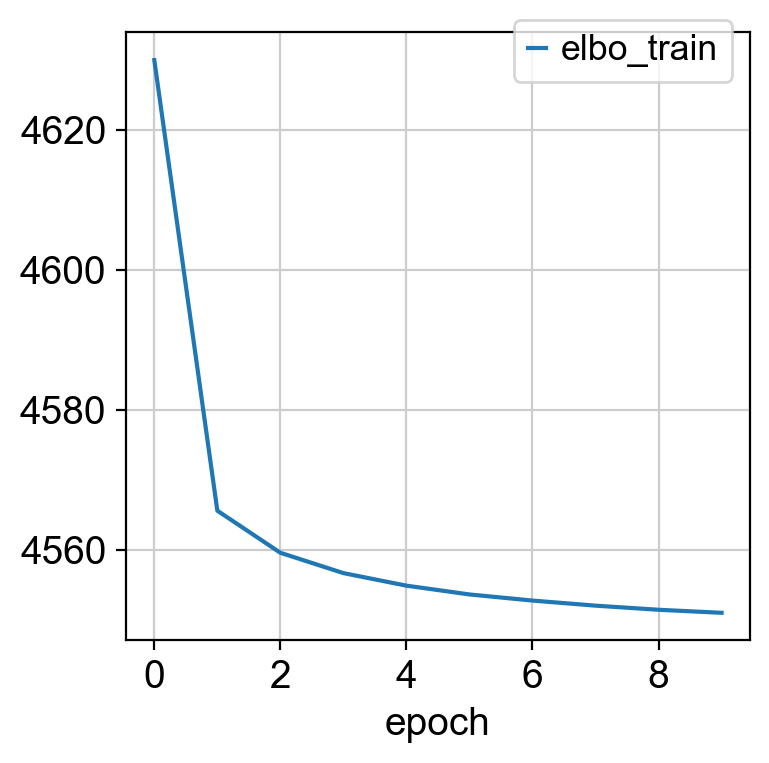

In [20]:
pd.concat(new_model.history.values(), axis=1).reset_index().plot('epoch', ['elbo_train'])
plt.legend(bbox_to_anchor=(1, 1.05))

Looks alright. Check that batch correction is preserved as in the example above:

In [21]:
target_batch = 'Meyer_2019'
recon = new_model.get_normalized_expression(full_subset, transform_batch=target_batch)

# construct anndata
recon_adata = ad.AnnData(recon, obs=full_subset.obs, var=full_subset.var)
recon_adata.uns['scanvi_label_colors'] = full_subset.uns['scanvi_label_colors']

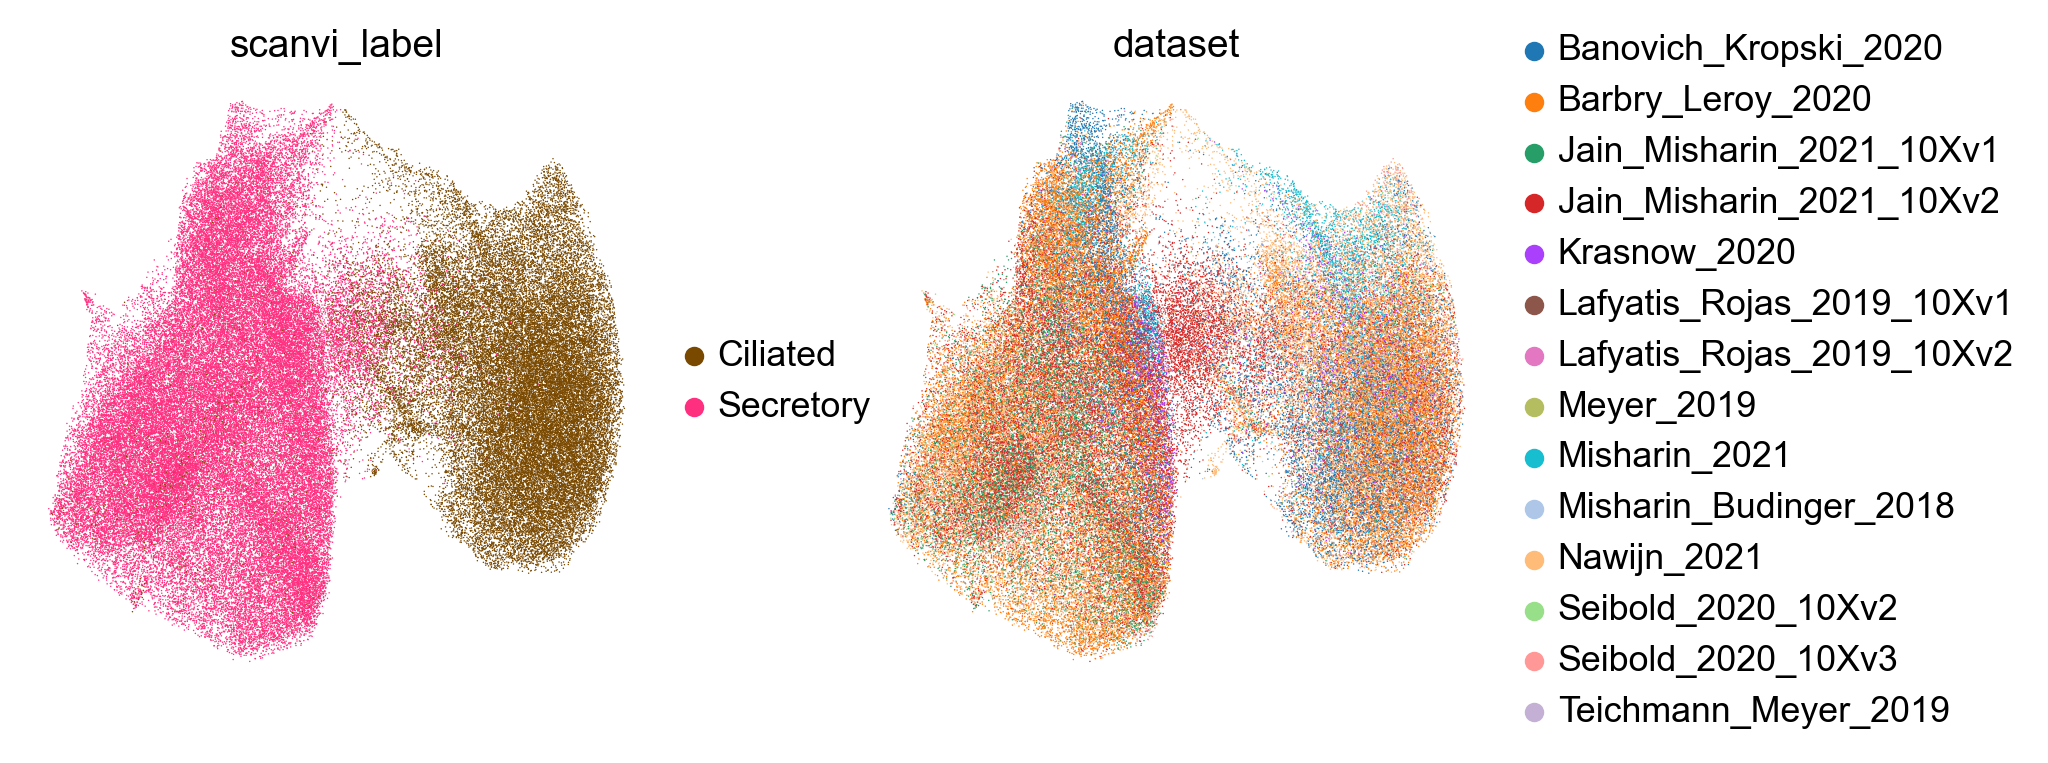

CPU times: user 3min 56s, sys: 8.71 s, total: 4min 4s
Wall time: 2min 26s


In [8]:
%%time
sc.tl.pca(recon_adata)
sc.pp.neighbors(recon_adata)
sc.tl.umap(recon_adata)
sc.pl.umap(recon_adata, color=['scanvi_label', 'dataset'])

## performance

Measure performance of reconstructed gene expression values:

In [107]:
def get_reconstruction_values(adata_true, pred_df, hvgs=hvgs):
    res = {
        'hvg': {'pearson':[], 'r2':[], 'genes':[]},
        'non-hvg': {'pearson':[], 'r2':[], 'genes':[]}
    }
    for i, gene in enumerate(adata_true.var_names):
        cat = 'hvg' if gene in hvgs else 'non-hvg'
        
        if cat == 'non-hvg' and len(res['non-hvg']['pearson']) >= 2000:  # to save time
            continue

        true = adata_true.X[:, i].toarray().flatten()
        if type(pred_df) == pd.core.frame.DataFrame:
            pred = pred_df[[gene]].values.flatten()
        else:  # assume array
            pred = pred_df[:, i]
        res[cat]['r2'].append(r2_score(true, pred))
        res[cat]['pearson'].append(pearsonr(true, pred)[0])
        res[cat]['genes'].append(gene)
        if i > 1000:  # save time
            break

    return res

In [23]:
recon = new_model.get_normalized_expression(full_subset, transform_batch=None)  # switch to full adata later

In [108]:
%%time
res = get_reconstruction_values(full_subset, recon)

/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 13min 7s, sys: 11min 47s, total: 24min 55s
Wall time: 8min 52s


<AxesSubplot:xlabel='variable', ylabel='value'>

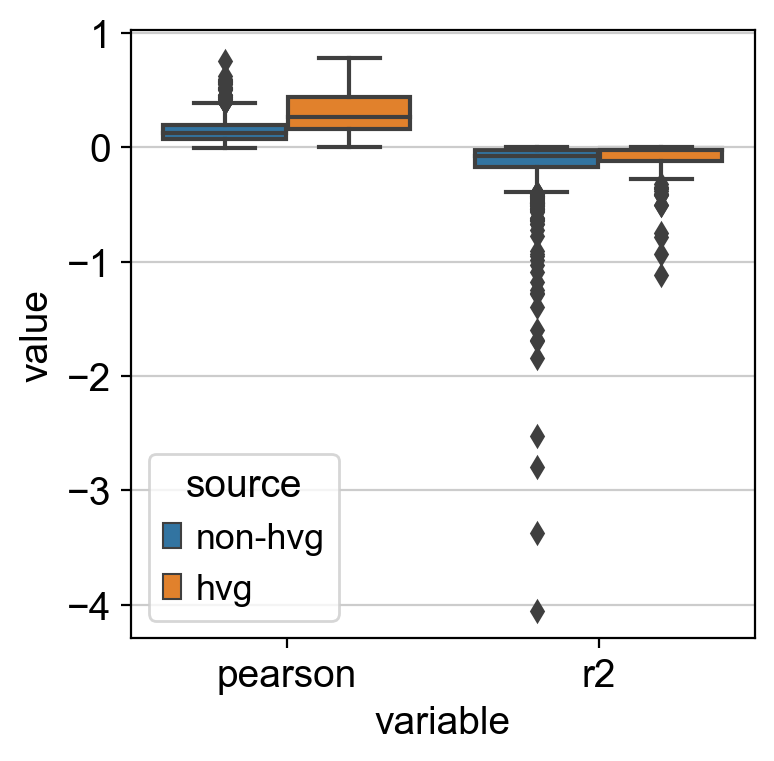

In [109]:
df1 = pd.DataFrame.from_dict(res['non-hvg'])
df1['source'] = 'non-hvg'
df2 = pd.DataFrame.from_dict(res['hvg'])
df2['source'] = 'hvg'
df = pd.concat([df1, df2])

sns.boxplot(x='variable', y='value', data=df.melt(id_vars=['source', 'genes']), hue='source')

In [36]:
# summary of recon
print('all:', r2_score(full_subset.X.toarray(), recon.values))
print('hvgs:', r2_score(full_subset[:, hvgs].X.toarray(), recon[hvgs].values))
print('non-hvgs:', r2_score(full_subset[:, nonhvgs].X.toarray(), recon[nonhvgs].values))

all: -0.0976299076453721
hvgs: -0.12510379821545517
non-hvgs: -0.09555851694381648


and compared to the old model:

In [78]:
source_recon = source_model.get_normalized_expression(subset, transform_batch=None)  # switch to full adata later

In [110]:
%%time
source_res = get_reconstruction_values(subset, source_recon)

/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 5min 49s, sys: 9min 26s, total: 15min 15s
Wall time: 2min 32s


Summary plot:

In [111]:
%%time
linreg_res = get_reconstruction_values(full_subset, pred)

/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 13min 27s, sys: 11min 51s, total: 25min 18s
Wall time: 9min


In [112]:
%%time
# get a random result
index = np.arange(full_subset.shape[0])
np.random.shuffle(index)
random_res = get_reconstruction_values(full_subset, full_subset.X[index, :].toarray())

/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/icb/yuge.ji/miniconda3/envs/py37_hlca/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 13min 20s, sys: 11min 54s, total: 25min 14s
Wall time: 9min 8s


(-3.0, 1.1)

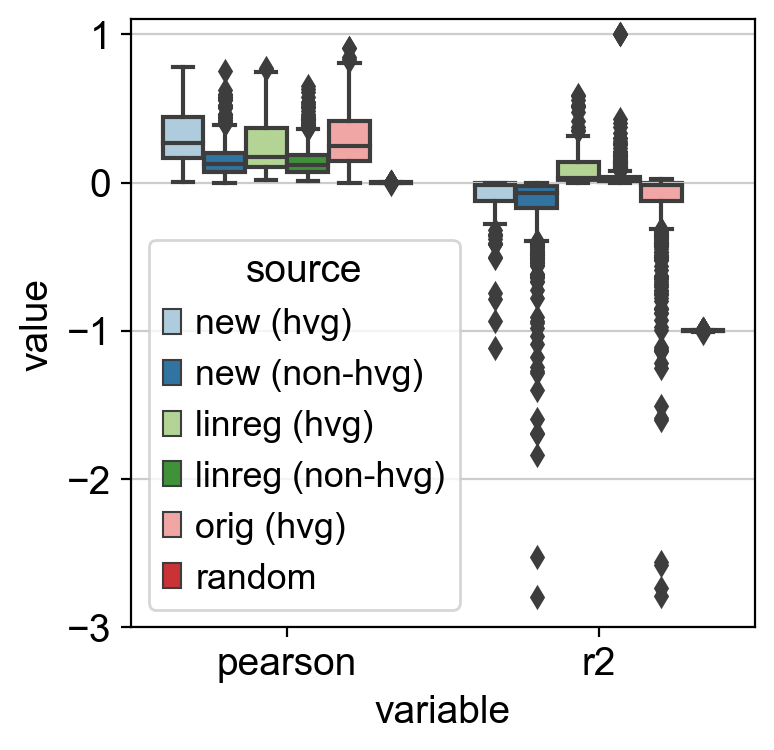

In [113]:
df2 = pd.DataFrame.from_dict(res['hvg'])
df2['source'] = 'new (hvg)'
df3 = pd.DataFrame.from_dict(res['non-hvg'])
df3['source'] = 'new (non-hvg)'
df4 = pd.DataFrame.from_dict(linreg_res['hvg'])
df4['source'] = 'linreg (hvg)'
df5 = pd.DataFrame.from_dict(linreg_res['non-hvg'])
df5['source'] = 'linreg (non-hvg)'
df1 = pd.DataFrame.from_dict(source_res['hvg'])
df1['source'] = 'orig (hvg)'
rdf = pd.DataFrame.from_dict(random_res['hvg'])
rdf['source'] = 'random'
df = pd.concat([df2, df3, df4, df5, df1, rdf])

sns.boxplot(x='variable', y='value', data=df.melt(id_vars=['source', 'genes']), hue='source', palette='Paired')
plt.ylim(-3, 1.1)

In [41]:
# summary of recon
print('all/hvgs:', r2_score(subset.X.toarray(), source_recon.values))

all/hvgs: -0.12319072456257703


Is it possible that non-hvgs are biased towards poor performance because of of differences in mean expression?

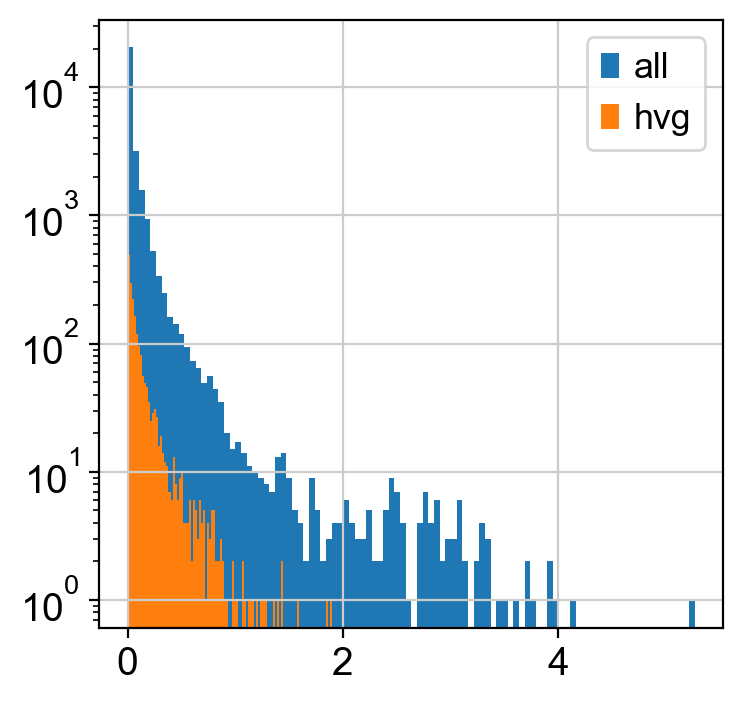

In [55]:
# plot means
plt.hist(full_adata.var.means.values, bins=100, label='all')
plt.hist(adata.var.means.values, bins=100, label='hvg')
plt.yscale('log')
plt.legend()

In [114]:
# bin means
bins = [-1, 0.5, 1, 2, 4, np.inf]
full_adata.var['bins'] = pd.cut(full_adata.var['means'], bins)
df['bins'] = df['genes'].map(dict(zip(full_adata.var.index, full_adata.var.bins)))
df

pearson        r2     genes     source         bins
0    0.331647 -0.002260       FGR  new (hvg)  (-1.0, 0.5]
1    0.289645 -0.353680       CFH  new (hvg)  (-1.0, 0.5]
2    0.365728 -0.377813    HS3ST1  new (hvg)  (-1.0, 0.5]
3    0.261256 -0.026700  TMEM176A  new (hvg)  (-1.0, 0.5]
4    0.404836 -0.068661      TFPI  new (hvg)  (-1.0, 0.5]
..        ...       ...       ...        ...          ...
101  0.003817 -0.992367      TIE1     random  (-1.0, 0.5]
102 -0.000862 -1.001725      CD84     random  (-1.0, 0.5]
103 -0.004896 -1.009791      SPI1     random  (-1.0, 0.5]
104 -0.002395 -1.004789    CLDN18     random  (-1.0, 0.5]
105 -0.000320 -1.000640     PLPP1     random  (-1.0, 0.5]

[3112 rows x 5 columns]

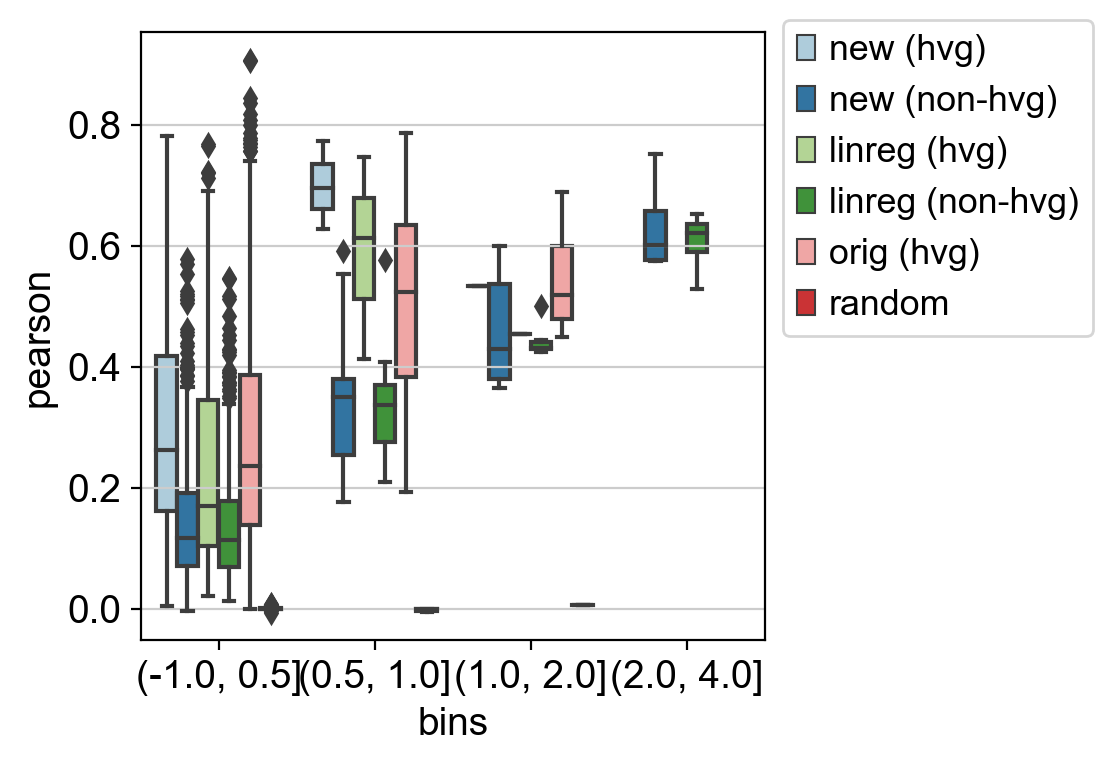

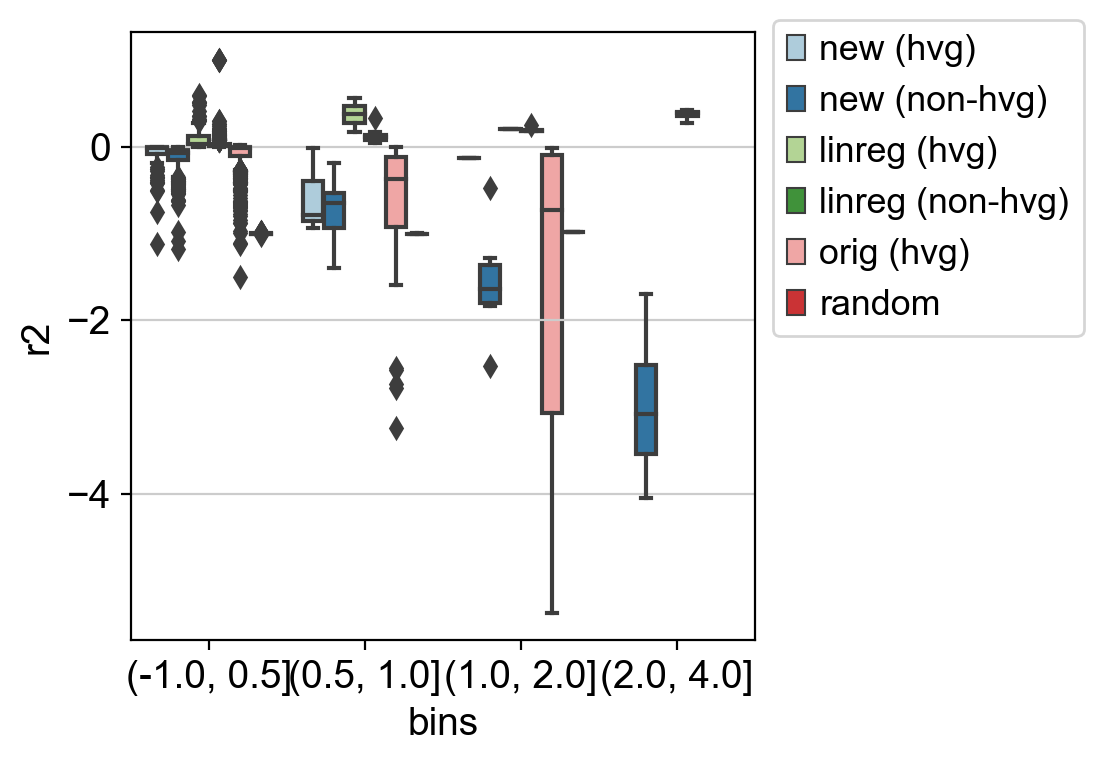

In [115]:
sns.boxplot(data=df, x='bins', y='pearson', hue='source', palette='Paired')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

sns.boxplot(data=df, x='bins', y='r2', hue='source', palette='Paired')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

So, non-hvgs still systematically perform worse across mean values.

In [116]:
# save dataframe of results
df.to_csv('full_geneset_reconstruction_res.csv')

Check reconstruction via UMAP:

In [36]:
# construct anndata
recon_adata = ad.AnnData(recon, obs=full_subset.obs, var=full_subset.var)
recon_adata.uns['scanvi_label_colors'] = full_subset.uns['scanvi_label_colors']

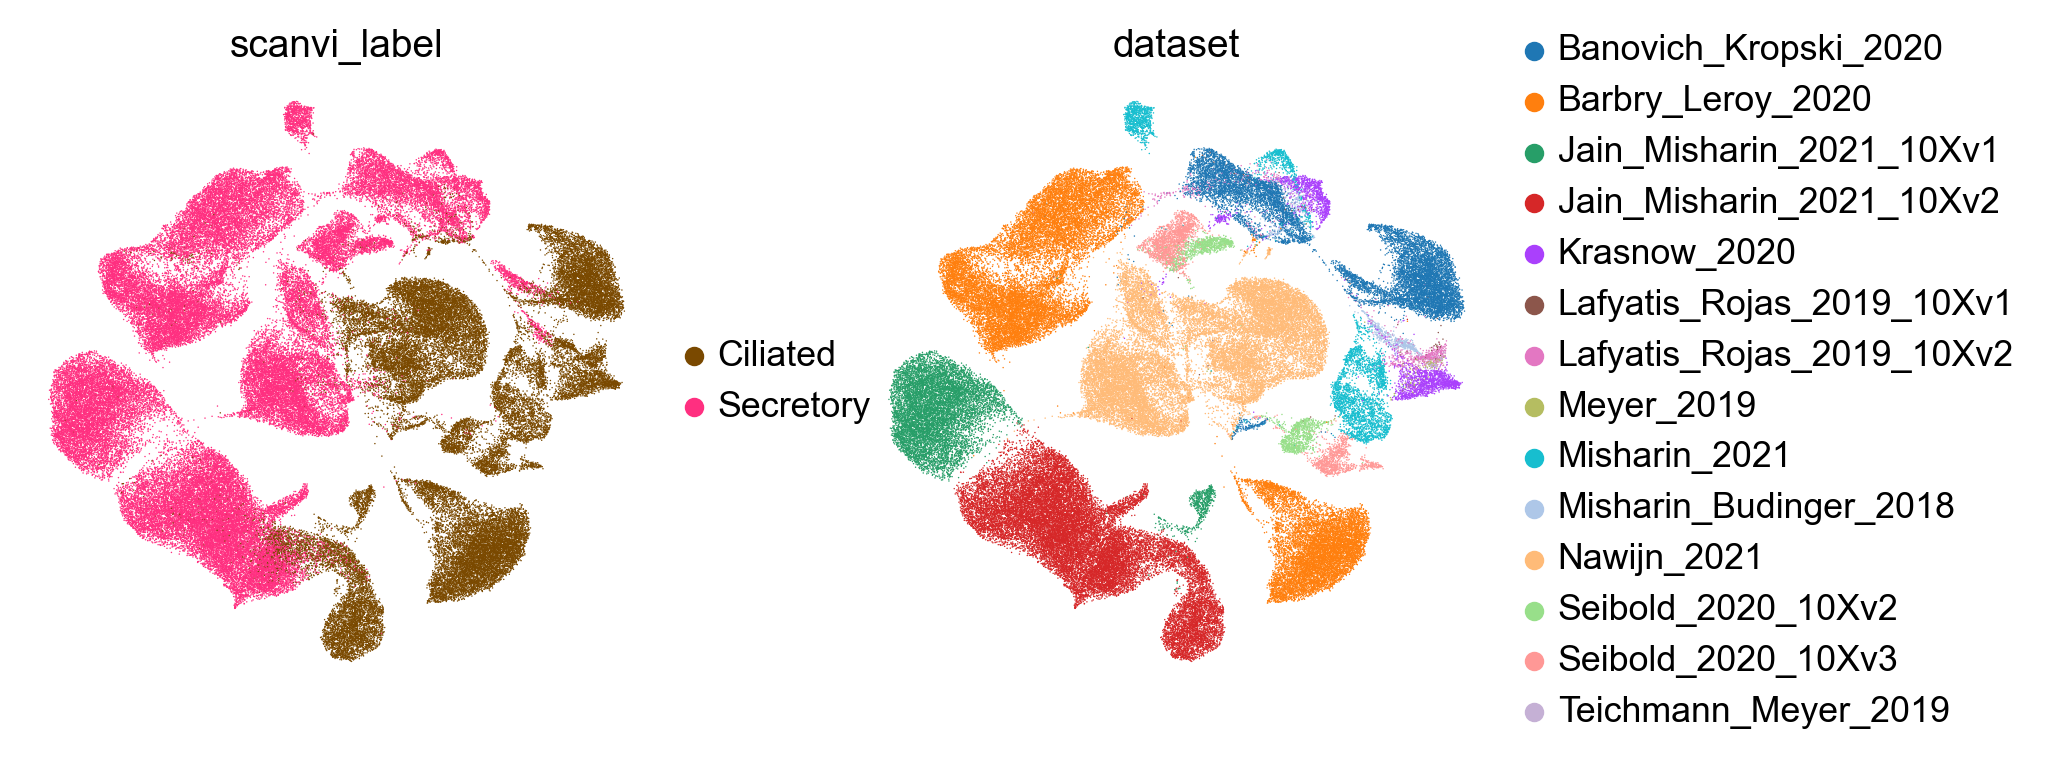

CPU times: user 4min 39s, sys: 9.91 s, total: 4min 49s
Wall time: 2min 27s


In [11]:
%%time
sc.tl.pca(recon_adata)
sc.pp.neighbors(recon_adata)
sc.tl.umap(recon_adata)
sc.pl.umap(recon_adata, color=['scanvi_label', 'dataset'])

Comparing this to block [7] in this notebook, we see that there is much less resolution within each label for whatever variation was not capture by the labels given to scANVI (aka, the model was not able to reconstruct that variation because it was not represented in the latent variables), but there is still most of it.

Visualize these reconstructed values (specifically, the performance difference linreg and the model comes down to zinb reconstruction loss not being measured well with r2)

In [46]:
recon_adata.obs['source'] = 'recon'
full_subset.obs['source'] = 'original'
full_linreg = full_subset.copy()
full_linreg.X = pred = reg.predict(z)
full_linreg.obs['source'] = 'linreg'

both = ad.concat([recon_adata, full_subset, full_linreg])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


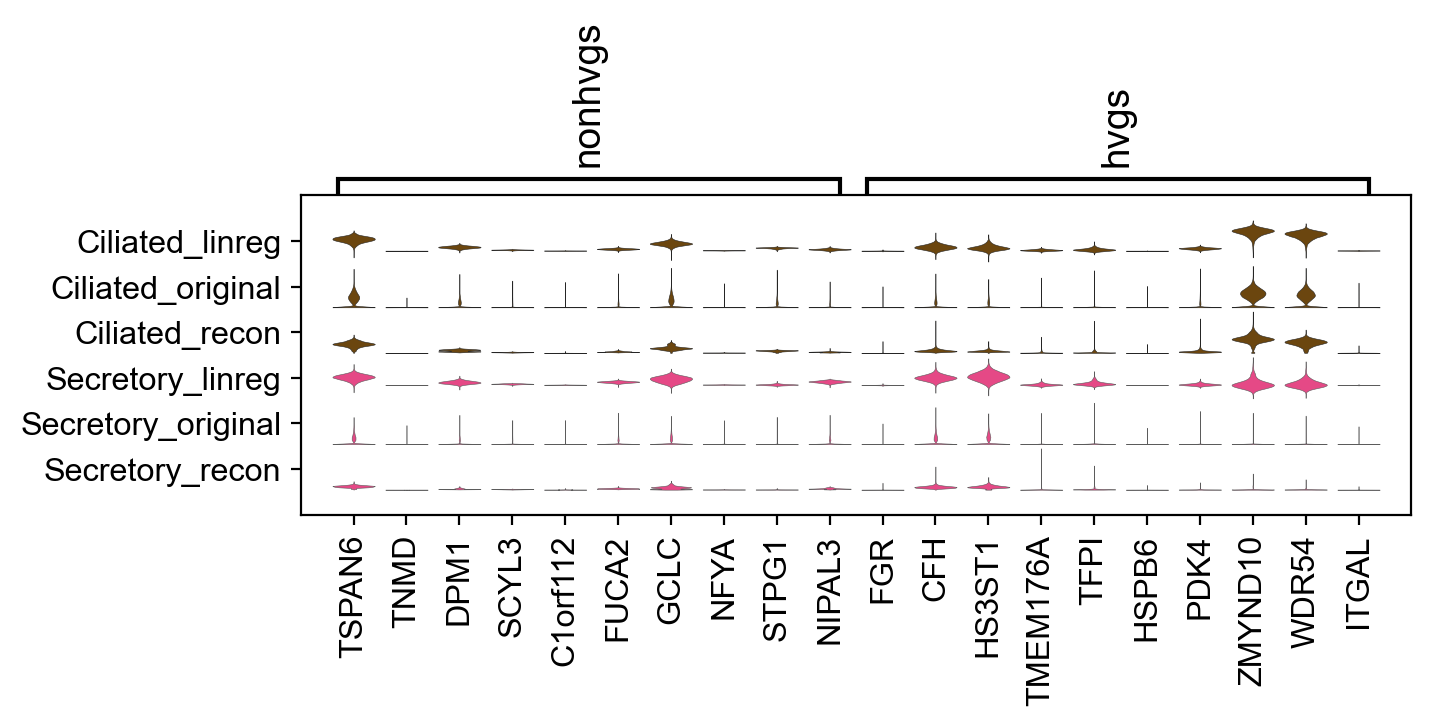

In [56]:
sc.pl.stacked_violin(both, var_names={'non-hvgs':nonhvgs[:10], 'hvgs':hvgs[:10]}, groupby=['scanvi_label', 'source'],
    row_palette=['#7A4900', '#7A4900', '#7A4900', '#FF2F80', '#FF2F80', '#FF2F80'])